# Overview

In this notebook, we take a look at the Carbon Monoxide (CO) levels in the US and see whether there are any trends that the data supports.

In [1]:
%%capture

# Installing the required libraries:
!pip install matplotlib pandas scikit-learn  
!pip install statsmodels==0.10.2 pyarrow tensorflow
!pip install google-cloud-bigquery google-cloud-bigquery-storage

In [2]:
# Third Party Libraries
import pandas as pd
from statsmodels.tsa import seasonal
from google.cloud import bigquery
import matplotlib.pyplot as plt

# Configurations
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Configurations

Let's make sure we enter the name of our GCP project in the next cell.

In [3]:
# ENTER THE GCP PROJECT HERE
gcp_project = "YOUR-GCP-PROJECT"
print(f"gcp_project is set to {gcp_project}")

gcp_project is set to gcp-public-data-contributors


Let's select a city to narrow down our investigation to one location:

In [4]:
city_name = "Las Vegas"
state_name = "Nevada"

### Authentication
The following cell authenticates the user through [Colab](https://colab.sandbox.google.com/). If you intend to run this notebook elsewhere, you will need to change the authentication code in the next cell accordingly.

In [5]:
from google.colab import auth

print("Authenticating in Colab...")
auth.authenticate_user()
print("Authenticated")

Authenticating in Colab...
Authenticated


In [6]:
bqclient = bigquery.Client(project=gcp_project)

## Data Preparation

### Query the Data

In [7]:
query = f"""
SELECT
  date_local AS date, AVG(arithmetic_mean) AS co_level
FROM
  `bigquery-public-data.epa_historical_air_quality.co_daily_summary`
WHERE
  city_name = \"{city_name}\" AND
  state_name = \"{state_name}\" AND
  aqi IS NOT NULL
GROUP BY
  date_local;
"""

In [8]:
dataframe = bqclient.query(query).result().to_dataframe()

In [9]:
dataframe.head()

,date,co_level
0,1992-01-01,1.750000
1,1992-01-09,1.370833
2,1992-01-14,2.468750
3,1992-01-15,1.016666
4,1992-01-18,1.145833


### Check the Dataframe



In [10]:
dataframe["date"] = dataframe["date"].astype("datetime64[ns]").apply(pd.Timestamp)
dataframe["year"] = dataframe["date"].dt.year
dataframe["month"] = dataframe["date"].dt.month
dataframe["year-month"] = dataframe[["year", "month"]].apply(lambda x: f"{x[0]}-{x[1]:02d}", axis=1)

In [11]:
print(dataframe.shape)
dataframe.head()

(11642, 5)


,date,co_level,year,month,year-month
0,1992-01-01,1.750000,1992,1,1992-01
1,1992-01-09,1.370833,1992,1,1992-01
2,1992-01-14,2.468750,1992,1,1992-01
3,1992-01-15,1.016666,1992,1,1992-01
4,1992-01-18,1.145833,1992,1,1992-01


### Analysis

A quick plot of the data shows that there is a clear downward trend in the CO level. We can also see there is a seosanlity.

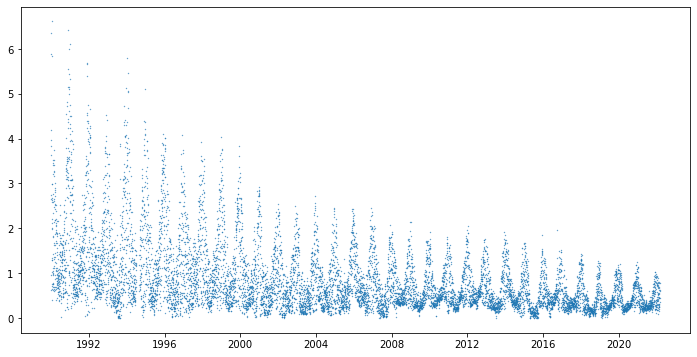

In [12]:
plt.figure(figsize=(12, 6))
plt.scatter(dataframe["date"], dataframe["co_level"], s=0.1);

We can smooth out the graph and work with a smaller size of data by taking the average of CO for each month of each year:

In [13]:
ts_df = dataframe[["year-month", "co_level"]].groupby("year-month").mean().reset_index()
ts_df = ts_df.sort_values(by=["year-month"])
ts_df.head()

,year-month,co_level
0,1990-01,2.595684
1,1990-02,1.988393
2,1990-03,1.816453
3,1990-04,1.447112
4,1990-05,0.881705


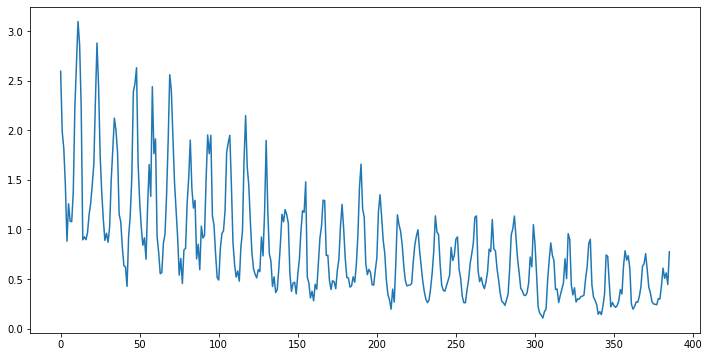

In [14]:
plt.figure(figsize=(12, 6))
ts_df["co_level"].plot();

Let's look at the same plot, but for years 1991 to 1993 only:

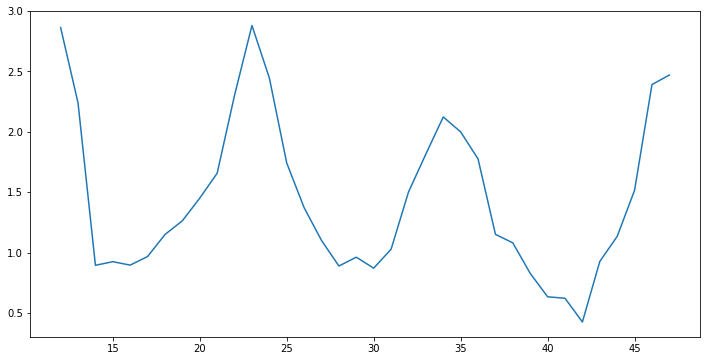

In [15]:
plt.figure(figsize=(12, 6))
ts_df[ts_df["year-month"].apply(lambda x: 1990 < int(x[:4]) < 1994)]["co_level"].plot();

There is clearly an annual bump. So, we have a seasonality which is annual. Let's see if we can decompose the trend and seasonality:

In [16]:
decomposed = seasonal.seasonal_decompose(ts_df["co_level"].values, freq=12)

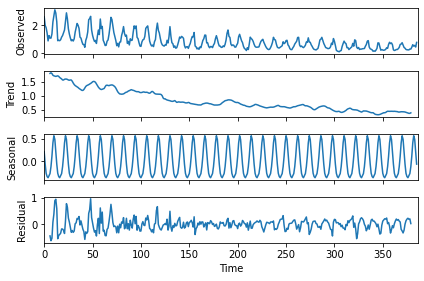

In [17]:
decomposed.plot();

The plot above shows a clear downward trend and the existence of seasanality.

Another way to look at it is by simply averaging the CO values over months, and over years:

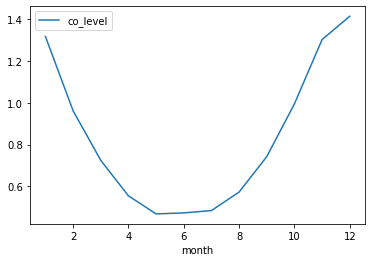

In [18]:
# The monthly plot for the CO levels:
month_df = dataframe[["month", "co_level"]].groupby("month").mean()
month_df.plot();

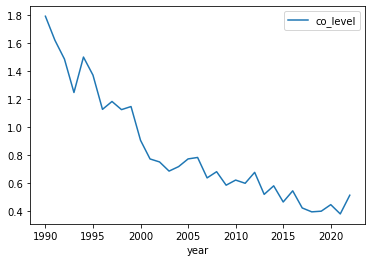

In [19]:
# The yearly plot for the CO levels:
year_df = dataframe[["year", "co_level"]].groupby("year").mean()
year_df.plot();